# Table detection with `SCIPY_PROJ` method

This is the default method for table detection.

The algorithm in behind this method can be approximately described as follows:

- We start from a grayscale pre-processed image from {meth}`dawsonia.image_preproc.Preprocessor.preprocess` which undergoes the following:
    - colors transformed to grayscale
    - background noise removed
    - corrective rotation applied (optional)
    - text removed, grid lines filtered out and thickened
- Distinct tables are identified using {func}`scipy.ndimage.label` which assigns a label to a group of connected lines. See {func}`dawsonia.table_detect.scipy_proj.table_detect_scipy_proj` for the implementation.
- The function {func}`dawsonia.table_detect.scipy_proj.projections_of_label_tables` applies projection along horizontal and vertical directions.
- For different values of a factor called `sensibility`, the function {func}`dawsonia.table_detect.scipy_proj.get_table_structure` identifies peaks to get x and y coordinates for every row and column.
- Row heights and column widths are calculated using {func}`dawsonia.table_detect.scipy_proj.get_position`.
- Table cells are sorted in left-to-right, top-to-bottom order using {func}`dawsonia.table_detect.scipy_proj.sort_insertion`.
- Leading row and columns are removed (optional)
- If table structure matches as expected from the table formats file, then the result is appended to two lists.

In [1]:
%matplotlib inline

We start by setting the environment variable in Bash,
```sh
export DAWSONIA_DEBUG_TABLE_DETECT=1
```

or in the Python console:

In [2]:
import os
os.environ["DAWSONIA_DEBUG_TABLE_DETECT"] = "1"

Now, you need some data to get started. 
The HTR model weights and data file strucuture are stored in another git repository.

```{note}
You may notice that that the example journal files used in this page are missing from the git repository. These are not released openly as of now, but it could be available in the future. Please contact us if you are interested.
```

In [4]:
!git clone https://git.smhi.se/ai-for-obs/data.git

fatal: destination path 'data' already exists and is not an empty directory.


## Input data and table formats configuration

The data repository contains a Zarr directory (we support both PDFs and [Zarr files of all formats](https://zarr.readthedocs.io/en/stable/api/storage.html)) with scans of 5 pages each from two "books" of the weather station Bjuröklubb.

In [5]:
%ls -1 data/raw_zarr/bjuröklubb_example/

bjuröklubb_1927.zarr/
bjuröklubb_1930.zarr/


Before we start we need to at least create a [table formats](user_guide/misc.md#table-formats) configuration file. We do that by manually viewing the files. Visually we know that there are:

- 5 tables in each page
- each have a distinct number of rows and columns
- 2 tables that contains numeric values that are of interest to us
- the column and row names which are static values
- year 1927 and year 1930 has different table structures

The name of the file is important. Notice that the stem of the configuration file is the same as the parent directory which holds the books, which is `bjuröklubb_example`.

In [6]:
%mkdir -p table_formats

In [7]:
%%file table_formats/bjuröklubb_example.toml
# NOTE: that the file name matches the directory containing the files.
[default]
version = 0

# Default values, but wrote explicitly here. See PreprocConfig class
[default.preproc]
table_modif = true
corr_rotate = true
row_idx_unit = "HOURS"
idx_tables_size_verify = [0, 1]

[1927]
version = 1

[version.0]
columns = [
  [
    "term_på_baro",
    "barom",
    "torra_term",
    "våta_term",
    "moln_slag_lägre",
    "moln_mängd_lägre",
    "moln_slag_medel",
    "moln_slag_högre"
  ],
  [
    "moln_het_sol_dimma_nederbörd_total",
    "vind_riktning",
    "vind_beaufort",
    "vind_m_sek",
    "sikt",
    "sjögang",
    "maximi_term",
    "minimi_term",
    "nederbörd_mängd",
    "nederbörd_slag"
  ]
]
name_idx = "tid"
rows = [2, 8, 14, 19, 21]
tables = [
  [5, 8],
  [5, 10],
  [3, 1],
  [4, 2],
  [4, 5]
]

[version.1]
columns = [
  [
    "term_på_baro",
    "barom",
    "torra_term",
    "våta_term",
    "moln_slag_lägre",
    "moln_mängd_lägre",
    "moln_slag_högre",
    "moln_mängd_total"
  ],
  [
    "vind_riktning",
    "vind_beaufort",
    "vind_m_sek",
    "sikt",
    "sjögang",
    "maximi_term",
    "minimi_term",
    "nederbörd_mängd",
    "nederbörd_slag"
  ]
]
rows = [2, 8, 14, 19, 21]
tables = [
  [5, 8],
  [5, 9],
  [3, 1],
  [4, 2],
  [4, 5]
]

Overwriting table_formats/bjuröklubb_example.toml


## Demo: Table detection

Now that we have all the prerequisites read, let's execute the command:

```sh
DAWSONIA_DEBUG_TABLE_DETECT=1 dawsonia label --first-page 4 --last-page 4 --no-interactive data/raw_zarr/bjuröklubb_example/bjuröklubb_1927.zarr
```

or its Python API equivalent:

INFO     2024-05-20 12:17:03,235 - dawsonia.io._zarr - INFO - table_format = TableFormat(name_idx='tid',           
         columns=[['term_på_baro', 'barom', 'torra_term', 'våta_term', 'moln_slag_lägre', 'moln_mängd_lägre',      
         'moln_slag_högre', 'moln_mängd_total'], ['vind_riktning', 'vind_beaufort', 'vind_m_sek', 'sikt',          
         'sjögang', 'maximi_term', 'minimi_term', 'nederbörd_mängd', 'nederbörd_slag']], rows=(datetime.time(2, 0),
         datetime.time(8, 0), datetime.time(14, 0), datetime.time(19, 0), datetime.time(21, 0)), tables=[[5, 8],   
         [5, 9], [3, 1], [4, 2], [4, 5]], preproc=PreprocConfig(table_modif=True, corr_rotate=True,                
         row_idx_unit=<TimeUnits.HOURS: 1>, idx_tables_size_verify=[0, 1]), transforms=None, version='1',          
         station='bjuröklubb_example')

INFO     2024-05-20 12:17:03,257 - dawsonia.io._zarr - INFO - Setting first_page = 4

INFO     2024-05-20 12:17:03,263 - dawsonia.io._zarr - INFO - Setting first_page = 4

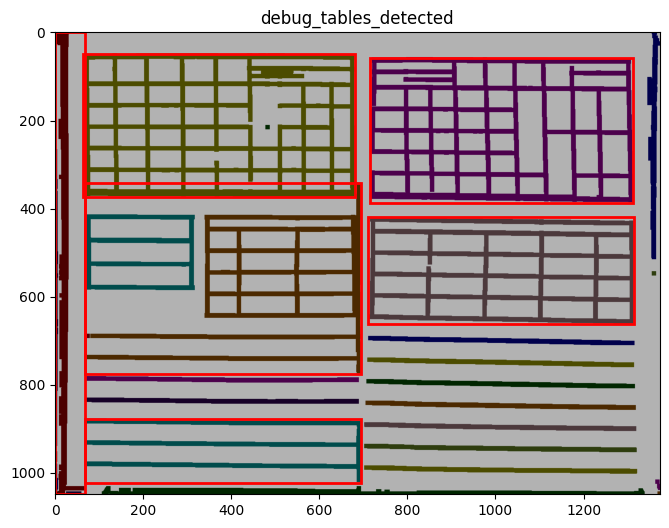

INFO     2024-05-20 12:17:09,201 - dawsonia.image_preproc - INFO - Expected size_tables = [[5, 8], [5, 9], [3, 1], 
         [4, 2], [4, 5]]. Detected nb_labels_pass = 6

INFO     2024-05-20 12:17:09,211 - dawsonia.image_preproc - INFO - with sensibility = 0.9: l_size = [[3, 6], [2,   
         6], [5, 5]]

INFO     2024-05-20 12:17:09,220 - dawsonia.image_preproc - INFO - with sensibility = 0.7: l_size = [[4, 8], [2,   
         9], [5, 5]]

INFO     2024-05-20 12:17:09,228 - dawsonia.image_preproc - INFO - with sensibility = 0.6: l_size = [[4, 8], [5,   
         9], [5, 5]]

INFO     2024-05-20 12:17:09,233 - dawsonia.image_preproc - INFO - saving table 1

INFO     2024-05-20 12:17:09,242 - dawsonia.image_preproc - INFO - with sensibility = 0.55: l_size = [[4, 8], [5,  
         9], [7, 3], [5, 5]]

INFO     2024-05-20 12:17:09,252 - dawsonia.image_preproc - INFO - with sensibility = 0.5: l_size = [[4, 8], [5,   
         9], [7, 3], [5, 5]]

INFO     2024-05-20 12:17:09,260 - dawsonia.image_preproc - INFO - with sensibility = 0.47: l_size = [[5, 8], [5,  
         9], [7, 3], [5, 5]]

INFO     2024-05-20 12:17:09,265 - dawsonia.image_preproc - INFO - saving table 0

INFO     2024-05-20 12:17:09,270 - dawsonia.image_preproc - INFO - 🌞 final size of tables: [[5, 8], [5, 9], [],   
         [], []]

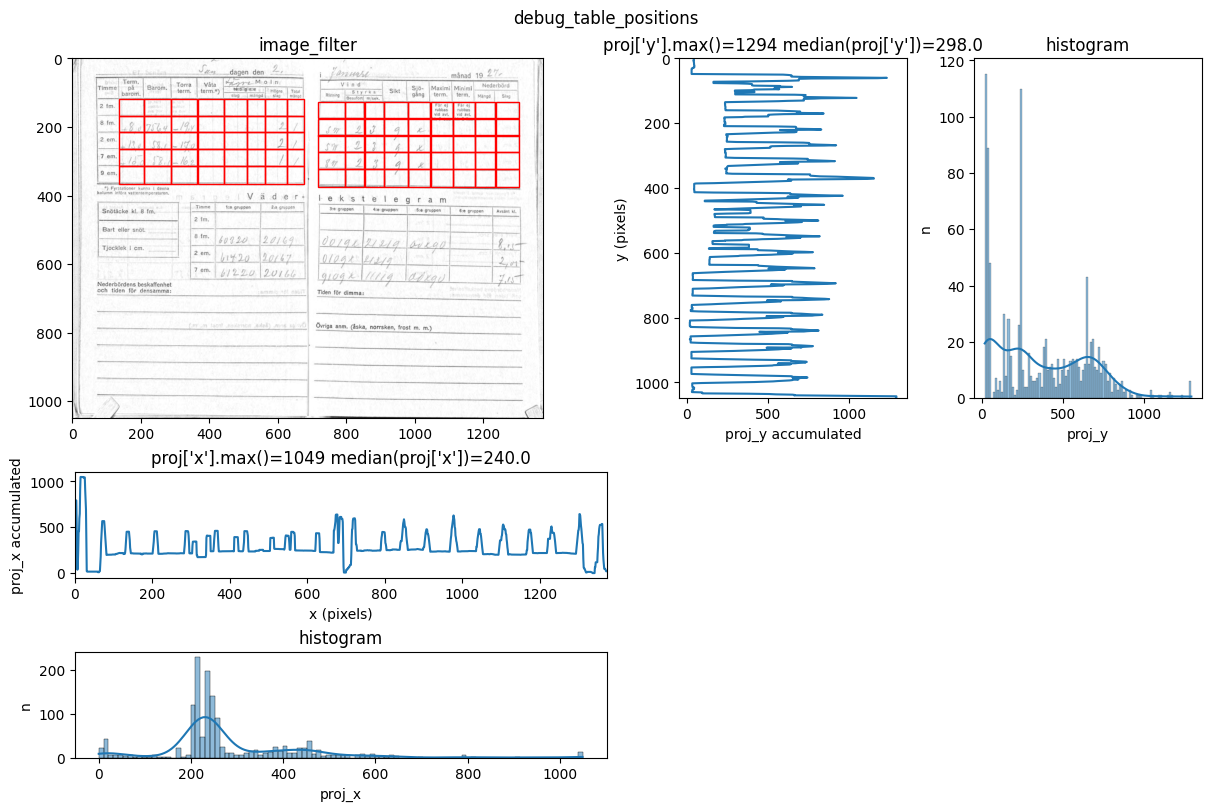

INFO     2024-05-20 12:17:12,108 - dawsonia.label - INFO - Table 2 not detected

INFO     2024-05-20 12:17:12,113 - dawsonia.label - INFO - Table 3 not detected

INFO     2024-05-20 12:17:12,118 - dawsonia.label - INFO - Table 4 not detected

In [8]:
from dawsonia import label

label.command("data/raw_zarr/bjuröklubb_example/bjuröklubb_1927.zarr", 4, 4, interactive=False)